In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import sys
sys.path.append(r"C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE")
import os as os

import VITAE
from VITAE.utils import load_data

import importlib
#importlib.reload(VITAE)

import pandas as pd
import scanpy as sc

dd = load_data(path = "D:/BioData", file_name = "mouse_brain_merged")

sc.pp.normalize_total(dd, target_sum=1e4)
sc.pp.log1p(dd)
sc.pp.highly_variable_genes(dd, min_mean=0.0125, max_mean=3, min_disp=0.5)


sc.pp.scale(dd, max_value=10)

sc.tl.pca(dd, svd_solver='arpack')
sc.pp.neighbors(dd, n_neighbors=10, n_pcs=40)

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [4]:
import random
import tensorflow as tf

tf.random.set_seed(
    seed = 1)
## Hyper parameters
npc = 64
model_type = "Gaussian"
hidden_layers = [32,16]
latent_space_dim = 8

clustering_res = 0.6
pi_prune_ratio = 0

n_posterior_samples = 10
beta = 1

In [5]:
dd.obs.columns = ['grouping', 'S_Score', 'G2M_Score', 'Source']

In [6]:
seed = 400
tf.keras.backend.clear_session()
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

model = VITAE.VITAE(adata = dd,
                 npc = npc, model_type = 'Gaussian',
                 hidden_layers = hidden_layers, latent_space_dim = latent_space_dim,
                 covariates = ['Source', 'S_Score', 'G2M_Score'])

model.pre_train(learning_rate=0.001,early_stopping_tolerance = 0.01, early_stopping_relative = True)

 92/200 [============>.................] - ETA: 2:16Best Epoch: 81. Best Metric: 50.528690.
Early stopping.
Pretrain Done.


In [7]:
model.init_latent_space(cluster_label= 'grouping', ratio_prune = pi_prune_ratio)

Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.


Calculate UMAP ...


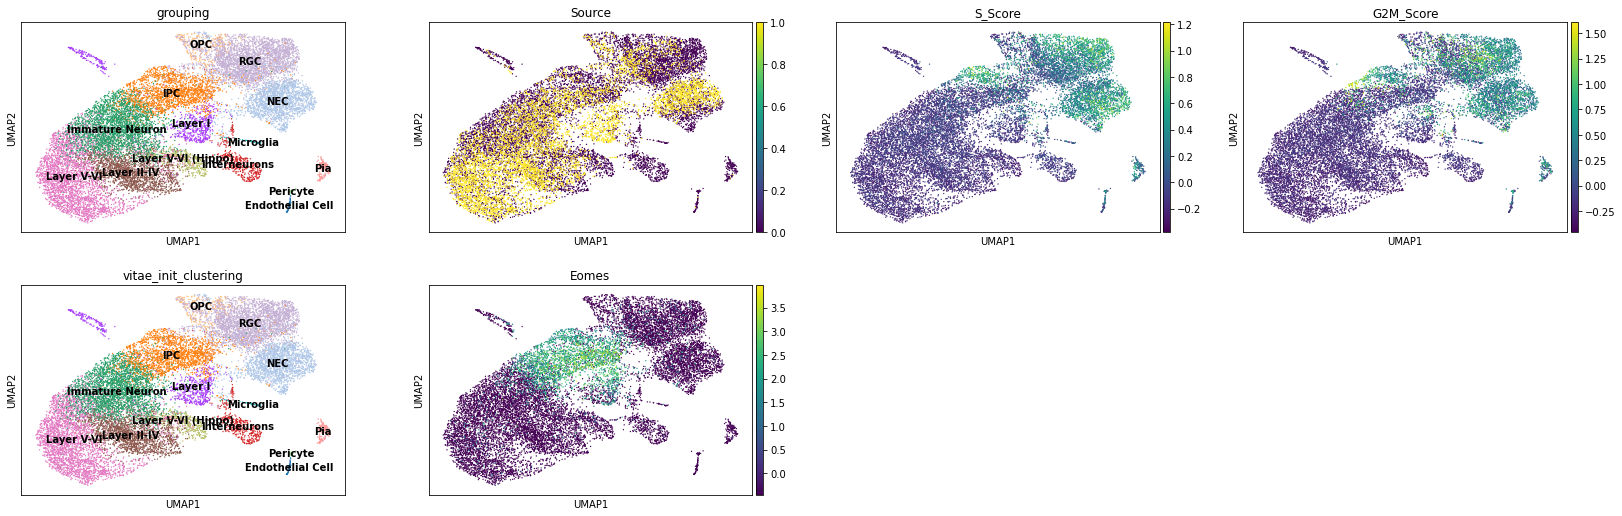

In [8]:
model.visualize_latent(color=['grouping', 'Source', 'S_Score', 'G2M_Score', 'vitae_init_clustering', 'Eomes'], method = "UMAP",legend_loc = 'on data')

In [9]:
model.train(beta = 1, learning_rate = 1e-3, early_stopping_tolerance = 0.01, early_stopping_relative = True)

Warmup:0
 44/200 [=====>........................] - ETA: 5:00Best Epoch: 32. Best Metric: 59.078907.
Early stopping.
Training Done!


In [10]:
model.posterior_estimation(batch_size=32, L=n_posterior_samples)

Computing posterior estimations over mini-batches.
521/521 [==============================] - 17s 32ms/step
New clustering labels saved as 'vitae_new_clustering' in self.adata.obs.


Calculate UMAP ...


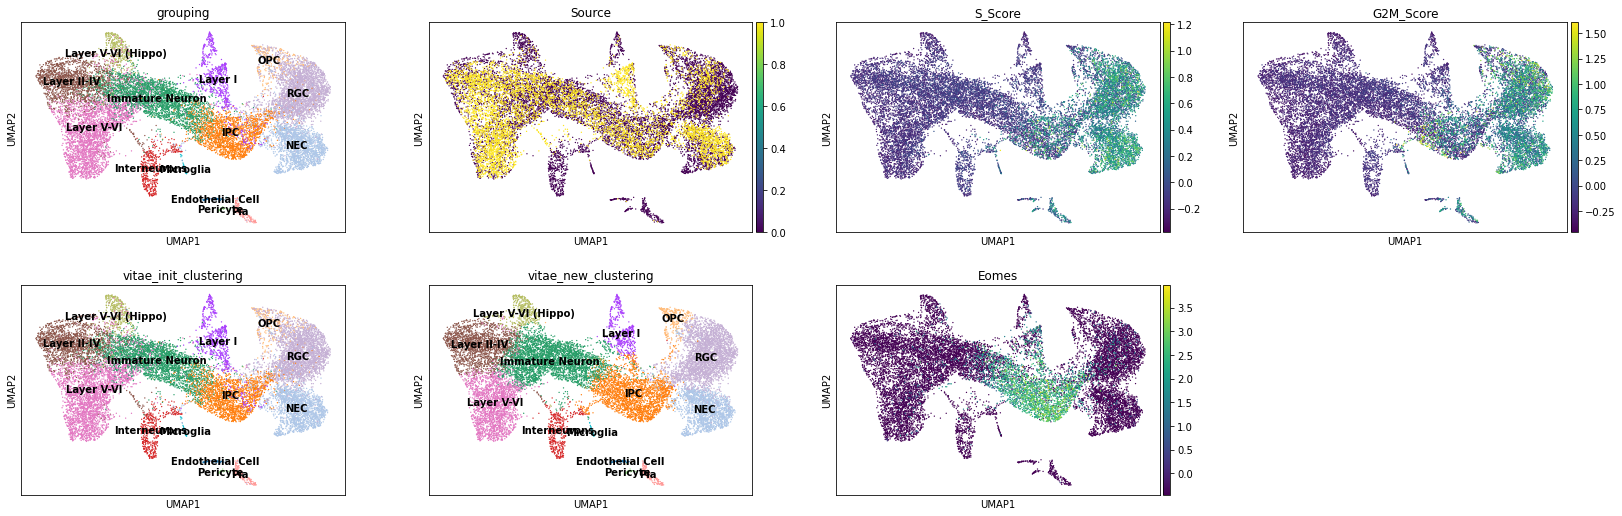

In [11]:
model.visualize_latent(color=['grouping', 'Source',  'S_Score', 'G2M_Score', 'vitae_init_clustering', 'vitae_new_clustering', 'Eomes'], method = "UMAP", legend_loc = 'on data')

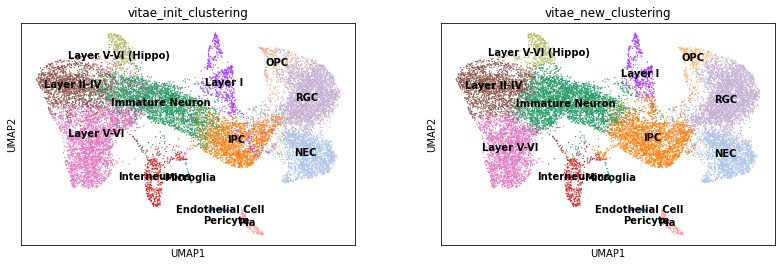

In [12]:
model.visualize_latent(color=['vitae_init_clustering', 'vitae_new_clustering'], method = "UMAP", legend_loc = 'on data')

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE\VITAE\VITAE.py:705: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


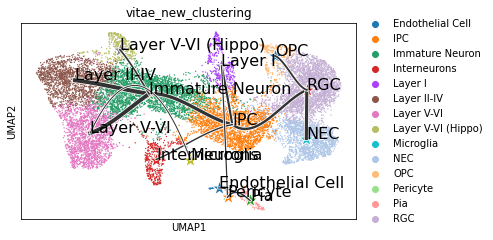

In [13]:
model.infer_backbone(cutoff = 0.0, no_loop = True, visualize = True,method = "modified_map")

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE\VITAE\VITAE.py:705: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


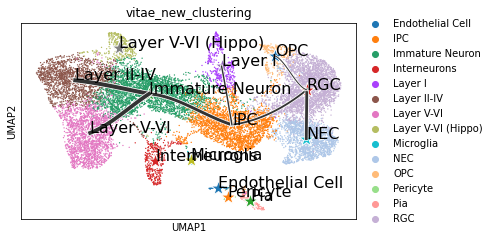

In [14]:
a = list(model.backbone.edges(data = True))
a = [x[2]["weight"] for x in a]
a = np.sort(a)[-7] - 1e-10
model.infer_backbone(cutoff = a, no_loop = True, visualize = True,method = "modified_map")

In [15]:
import seaborn
seaborn.set(rc={'figure.figsize':(15,12)},style = "white")

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE\VITAE\VITAE.py:705: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


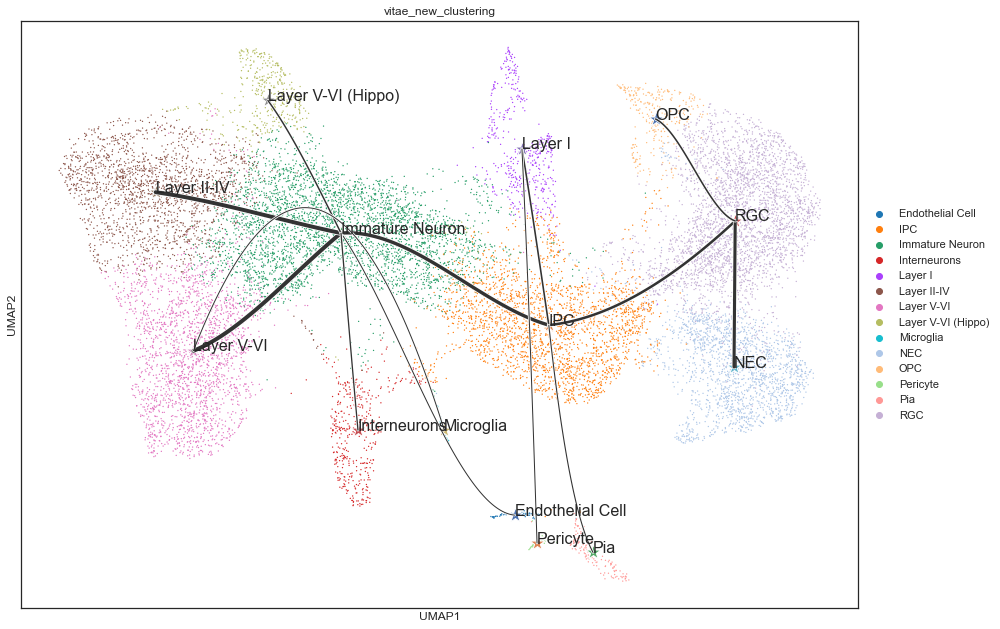

In [16]:
model.infer_backbone(cutoff = 0, no_loop = True, visualize = True,method = "raw_map")

In [17]:
a = list(model.backbone.edges(data = True))
a = [x[2]["weight"] for x in a]
a = np.sort(a)[-8] - 1e-10

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE\VITAE\VITAE.py:705: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


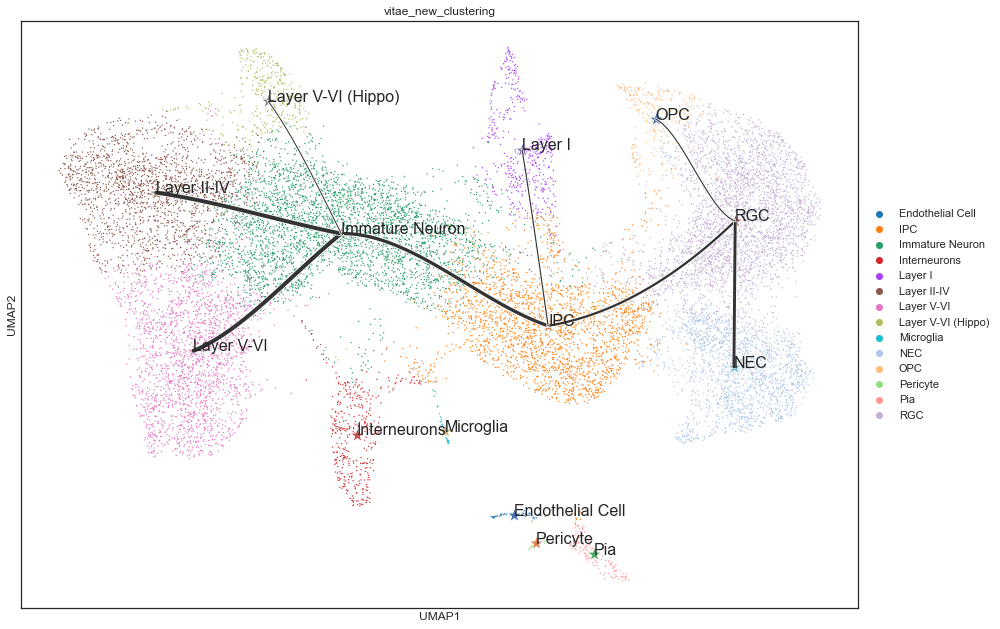

In [18]:
model.infer_backbone(cutoff = a, no_loop = True, visualize = True,method = "raw_map")

In [19]:
model.save_model("mouse.checkpoint")

In [20]:
model3 = VITAE.VITAE(adata = dd,
                 npc = npc, model_type = 'Gaussian',
                 hidden_layers = hidden_layers, latent_space_dim = latent_space_dim,
                 covariates = ['Source', 'S_Score', 'G2M_Score'])

In [21]:
model3.load_model("mouse.checkpoint",load_labels=True)

Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocast

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs
Calculate UMAP ...


C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE\VITAE\VITAE.py:705: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


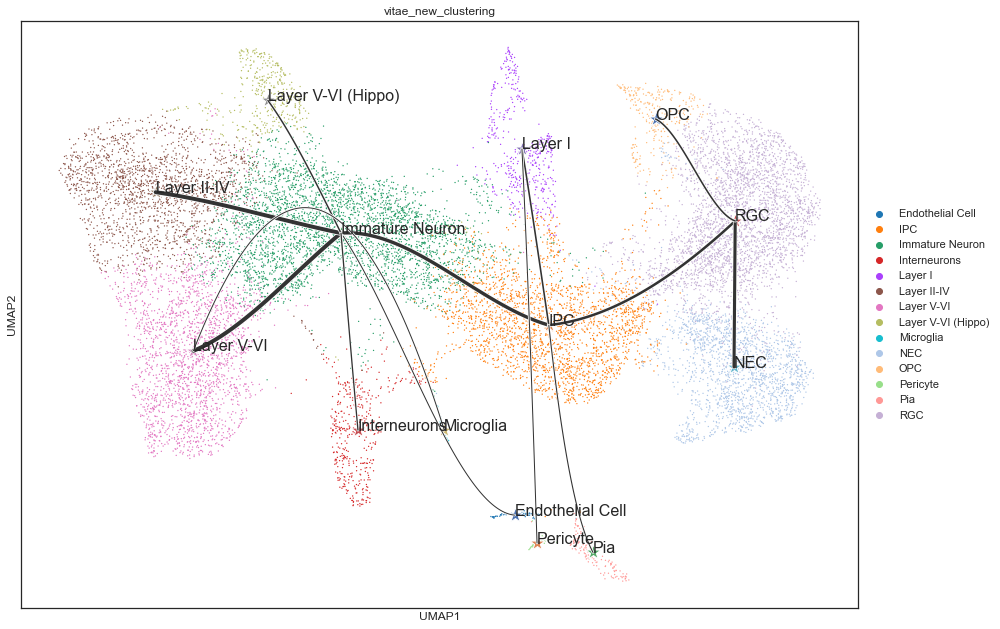

In [22]:
model3.infer_backbone(cutoff = 0, no_loop = True, visualize = True,method = "raw_map")

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE\VITAE\VITAE.py:705: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


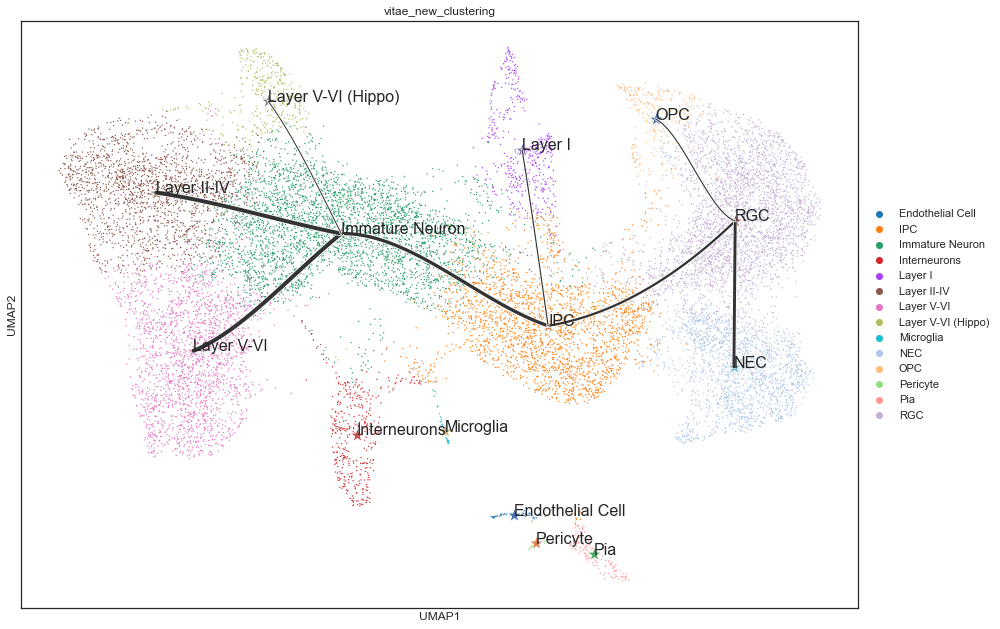

In [23]:
model3.infer_backbone(cutoff = a, no_loop = True, visualize = True,method = "raw_map")